Dataset: http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes

Replace zeros = NaN in some columns by median or mean

Feature Selection:
Principal Component Analysis (PCA)
Recursive Feature Elimination (RFE)
Feature Importance (e.g. by Gradient Boosting)

In [12]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA, NMF
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import Imputer

In [2]:
df = pd.read_csv('pima-indians-diabetes.data', header=None,
                 names=['preg', 'gluc', 'blood_p', 'skin', 'insu', 'bmi', 'pedi', 'age', 'class'])
df.head()

,preg,gluc,blood_p,skin,insu,bmi,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.describe()

,preg,gluc,blood_p,skin,insu,bmi,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
bins = range(10, 60, 6)
df['bmi_bin'] = pd.cut(df['bmi'], bins, labels=bins[:-1])
df.head()

,preg,gluc,blood_p,skin,insu,bmi,pedi,age,class,bmi_bin
0,6,148,72,35,0,33.6,0.627,50,1,28
1,1,85,66,29,0,26.6,0.351,31,0,22
2,8,183,64,0,0,23.3,0.672,32,1,22
3,1,89,66,23,94,28.1,0.167,21,0,28
4,0,137,40,35,168,43.1,2.288,33,1,40


In [5]:
grouped = df[['bmi_bin', 'class']].groupby(['bmi_bin'], as_index=False).mean()
grouped['class'] = grouped['class'].fillna(0.0)
df = df.drop('bmi_bin', axis=1)
grouped

,bmi_bin,class
0,10,0.000000
1,16,0.000000
2,22,0.153005
3,28,0.400810
4,34,0.433673
5,40,0.535211
6,46,0.588235
7,52,0.666667


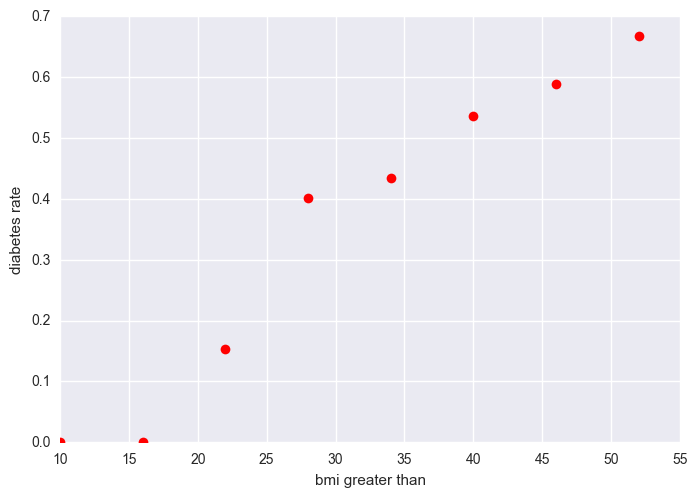

In [6]:
plt.plot(bins[:-1], grouped['class'], 'ro')
plt.xlabel('bmi greater than')
plt.ylabel('diabetes rate')
plt.show()

It's no surprise that overweight and diabetes are positively correlated.

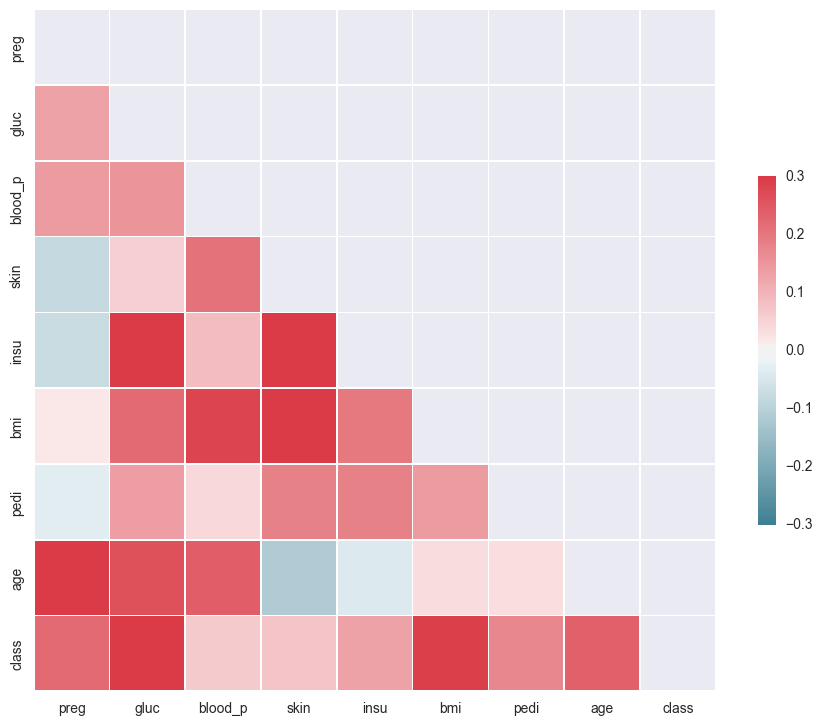

In [7]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [8]:
X, y = df.drop('class', axis=1), df['class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

~~~~
Best parameters set found on development set:

{'C': 1000, 'kernel': 'linear'}

Grid scores on development set:

0.687 (+/-0.047) for {'gamma': 0.001, 'C': 1, 'kernel': 'rbf'}
0.686 (+/-0.067) for {'gamma': 0.0001, 'C': 1, 'kernel': 'rbf'}
0.676 (+/-0.068) for {'gamma': 0.001, 'C': 10, 'kernel': 'rbf'}
0.692 (+/-0.062) for {'gamma': 0.0001, 'C': 10, 'kernel': 'rbf'}
0.634 (+/-0.070) for {'gamma': 0.001, 'C': 100, 'kernel': 'rbf'}
0.702 (+/-0.083) for {'gamma': 0.0001, 'C': 100, 'kernel': 'rbf'}
0.627 (+/-0.061) for {'gamma': 0.001, 'C': 1000, 'kernel': 'rbf'}
0.700 (+/-0.045) for {'gamma': 0.0001, 'C': 1000, 'kernel': 'rbf'}
0.717 (+/-0.067) for {'C': 1, 'kernel': 'linear'}
0.709 (+/-0.064) for {'C': 10, 'kernel': 'linear'}
0.713 (+/-0.060) for {'C': 100, 'kernel': 'linear'}
0.727 (+/-0.092) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.81      0.73      0.77        99
          1       0.58      0.69      0.63        55

avg / total       0.73      0.71      0.72       154
~~~~

Comparing different estimators in one grid search from http://www.codiply.com/blog/hyperparameter-grid-search-across-multiple-models-in-scikit-learn/

I had to make some adaptions to port it to Python 3 (should probably communicate them back to the author)

In [37]:
pipe = Pipeline([
    ('preprocessor', None),
    ('clf', LinearSVC())
])

N_ESTIMATORS_OPTIONS = [64]

print(X_train)

param_grid = [
    {
        'preprocessor' : [Imputer(missing_values=0, axis=0)],
        'preprocessor__strategy' : ['mean', 'median', 'most_frequent'],
        'clf' : [GradientBoostingClassifier()],
        'clf__n_estimators': N_ESTIMATORS_OPTIONS
    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=-1, param_grid=param_grid)
grid.fit(X_train, y_train)

results = dict()
results['mean'] = grid.cv_results_['mean_test_score']
results['std'] = grid.cv_results_['std_test_score']

for i, params in enumerate(grid.cv_results_['params']):
    for k, v in params.items():
        if k in ['preprocessor', 'clf']:
            v = str(v)
            v = v[:v.find('(')]
        if not k in results:
            results[k] = [None] * len(results['mean'])
        results[k][i] = v

pd.DataFrame.from_dict(results).sort_values('mean', ascending=False)

     preg  gluc  blood_p  skin  insu   bmi   pedi  age
60      2    84        0     0     0   0.0  0.304   21
618     9   112       82    24     0  28.2  1.282   50
346     1   139       46    19    83  28.7  0.654   22
294     0   161       50     0     0  21.9  0.254   65
231     6   134       80    37   370  46.2  0.238   46
340     1   130       70    13   105  25.9  0.472   22
535     4   132        0     0     0  32.9  0.302   23
306    10   161       68    23   132  25.5  0.326   47
718     1   108       60    46   178  35.5  0.415   24
90      1    80       55     0     0  19.1  0.258   21
377     1    87       60    37    75  37.2  0.509   22
235     4   171       72     0     0  43.6  0.479   26
158     2    88       74    19    53  29.0  0.229   22
69      4   146       85    27   100  28.9  0.189   27
260     3   191       68    15   130  30.9  0.299   34
131     9   122       56     0     0  33.3  1.114   33
44      7   159       64     0     0  27.4  0.294   40
70      2 

,clf,clf__n_estimators,mean,preprocessor,preprocessor__strategy,std
1,GradientBoostingClassifier,64,0.778502,Imputer,median,0.042932
0,GradientBoostingClassifier,64,0.776873,Imputer,mean,0.037339
2,GradientBoostingClassifier,64,0.776873,Imputer,most_frequent,0.029292
